In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 4.4 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107095 sha256=d51d4c4e7447a74cee47e5fef20b38596b10a1b8a718e9bb7967aa9e705b6db4
  Stored in directory: /Users/chieh/Library/Caches/pip/wheels/83/a6/12/bf3c1a667bde4251be5b7a3368b2d604c9af2105b5c1cb1870
Successfully built smart-open
  Using cached pandas-1.1.4-cp37-cp37m-macosx_10_9_x86_64.whl (9.9 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.3
    Uninstalling pandas-1.1.3:
      Successfully uninstalled pandas-1.1.3


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/chieh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# DATASET
DATASET_COLUMNS = ["TWID","TEXT","VALUE"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
dataset_filename = os.listdir("./data")[0]
dataset_path = os.path.join("./","data",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING ,
                 lineterminator='\n')

Open file: ./data/etd_full.csv


In [5]:
print("Dataset size:", len(df))

Dataset size: 2583220


In [6]:
df.head(10)

,TWID,TEXT,VALUE
0,1.467810e+09,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",-1
1,1.467811e+09,is upset that he can't update his Facebook by ...,-1
2,1.467811e+09,@Kenichan I dived many times for the ball. Man...,-1
3,1.467811e+09,my whole body feels itchy and like its on fire,-1
4,1.467811e+09,"@nationwideclass no, it's not behaving at all....",-1
5,1.467811e+09,@Kwesidei not the whole crew,-1
6,1.467812e+09,Need a hug,-1
7,1.467812e+09,@LOLTrish hey long time no see! Yes.. Rains a...,-1
8,1.467812e+09,@Tatiana_K nope they didn't have it,-1
9,1.467812e+09,@twittera que me muera ?,-1


In [8]:
# split a sample dataset, using smaller csv to train first
drop_item=df.sample(frac=0.9,random_state=200) #random state is a seed value
sample=df.drop(drop_item.index)

In [9]:
sample.head(10)

,TWID,TEXT,VALUE
2,1.467811e+09,@Kenichan I dived many times for the ball. Man...,-1
4,1.467811e+09,"@nationwideclass no, it's not behaving at all....",-1
21,1.467814e+09,"one of my friend called me, and asked to meet ...",-1
37,1.467817e+09,@MissXu sorry! bed time came here (GMT+1) ht...,-1
55,1.467822e+09,"@andywana Not sure what they are, only that th...",-1
68,1.467825e+09,@katortiz Not forever... See you soon!,-1
74,1.467826e+09,Why won't you show my location?! http://twit...,-1
78,1.467834e+09,i think my arms are sore from tennis,-1
125,1.467841e+09,@allyheman but.. but.. but.. I'm not a big fan...,-1
141,1.467843e+09,@ozesteph1992 Shame to hear this Stephan,-1


In [11]:
sample.to_csv("twitt_sample1.csv",index=False)

In [18]:
decode_map = {-1: "NEGATIVE", 0: "NEUTRAL", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [19]:
%%time
df.VALUE = df.VALUE.apply(lambda x: decode_sentiment(x))

CPU times: user 711 ms, sys: 14.1 ms, total: 725 ms
Wall time: 761 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

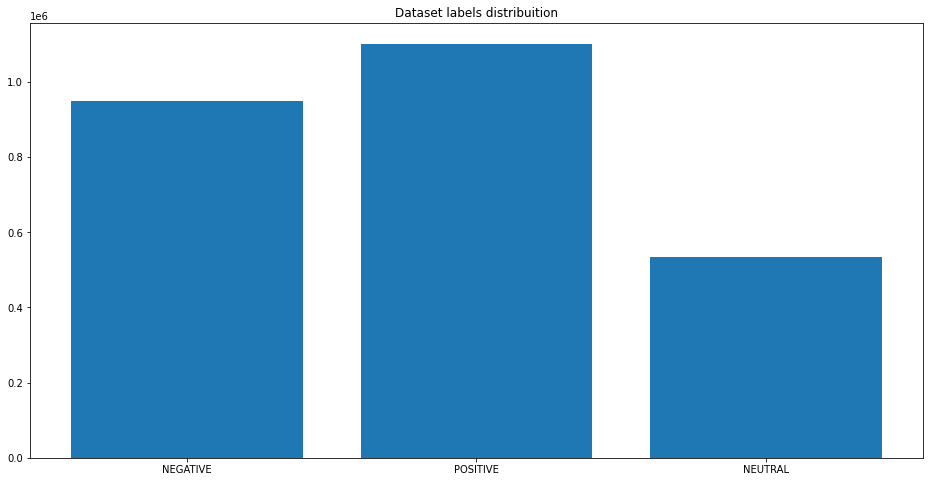

In [20]:
target_cnt = Counter(df.VALUE)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [21]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [23]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [24]:
%%time
df.TEXT = df.TEXT.apply(lambda x: preprocess(x))

CPU times: user 1min 17s, sys: 504 ms, total: 1min 18s
Wall time: 1min 20s


In [25]:
df.TEXT.head(10)

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
5                                           whole crew
6                                             need hug
7    hey long time see yes rains bit bit lol fine t...
8                                                 nope
9                                            que muera
Name: TEXT, dtype: object

In [26]:
df.head(10)

,TWID,TEXT,VALUE
0,1.467810e+09,awww bummer shoulda got david carr third day,NEGATIVE
1,1.467811e+09,upset update facebook texting might cry result...,NEGATIVE
2,1.467811e+09,dived many times ball managed save 50 rest go ...,NEGATIVE
3,1.467811e+09,whole body feels itchy like fire,NEGATIVE
4,1.467811e+09,behaving mad see,NEGATIVE
5,1.467811e+09,whole crew,NEGATIVE
6,1.467812e+09,need hug,NEGATIVE
7,1.467812e+09,hey long time see yes rains bit bit lol fine t...,NEGATIVE
8,1.467812e+09,nope,NEGATIVE
9,1.467812e+09,que muera,NEGATIVE
